In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf

In [3]:
df = "c:/Users/logonrmlocal/Documents/cats_and_dogs_filtered"

In [5]:
train_dir = df + "/train"
validation_dir = df + "/validation"

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size = IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [12]:
from platform import python_version

print(python_version())

3.9.12


In [13]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size = IMG_SIZE)

Found 1000 files belonging to 2 classes.


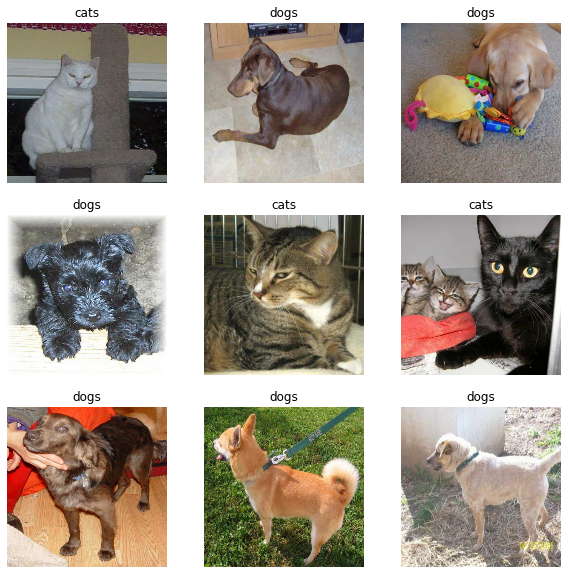

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [20]:
print(f"Número de batch de validação: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Número de batch de de teste: {tf.data.experimental.cardinality(test_dataset)}")

Número de batch de validação: 26
Número de batch de de teste: 6


In [22]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

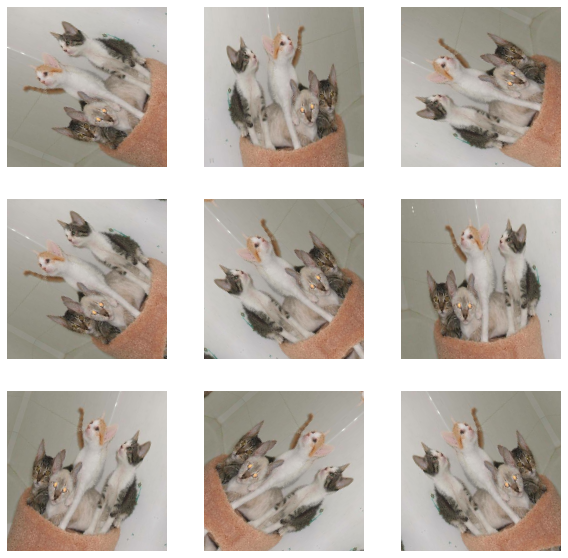

In [28]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [31]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [32]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top = False, weights = 'imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [33]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 5, 5, 1280)


In [34]:
base_model.trainable = False

In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [43]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [45]:
inputs = tf.keras.Input(shape=(160, 160, 3))
X = data_augmentation(inputs)
X = preprocess_input(X)
X = base_model(X, training = False)
X = global_average_layer(X)
X = tf.keras.layers.Dropout(.2)(X)

outputs = prediction_layer(X)
model = tf.keras.Model(inputs, outputs)

In [48]:
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [49]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 241ms/step - loss: 0.7245 - accuracy: 0.5631


In [50]:
print(f"Loss inicial: {loss0}")
print(f"Acurácia inicial: {accuracy0}")

Loss inicial: 0.7245228290557861
Acurácia inicial: 0.5631188154220581


In [51]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data = validation_dataset)

Epoch 1/10
63/63 [==============================] - 26s 365ms/step - loss: 0.6670 - accuracy: 0.6130 - val_loss: 0.4866 - val_accuracy: 0.7475
Epoch 2/10
63/63 [==============================] - 22s 348ms/step - loss: 0.5010 - accuracy: 0.7510 - val_loss: 0.3608 - val_accuracy: 0.8243
Epoch 3/10
63/63 [==============================] - 22s 348ms/step - loss: 0.4015 - accuracy: 0.8075 - val_loss: 0.2823 - val_accuracy: 0.8762
Epoch 4/10
63/63 [==============================] - 22s 347ms/step - loss: 0.3440 - accuracy: 0.8420 - val_loss: 0.2328 - val_accuracy: 0.9097
Epoch 5/10
63/63 [==============================] - 22s 348ms/step - loss: 0.3219 - accuracy: 0.8515 - val_loss: 0.2035 - val_accuracy: 0.9233
Epoch 6/10
63/63 [==============================] - 22s 348ms/step - loss: 0.2756 - accuracy: 0.8780 - val_loss: 0.1695 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 22s 349ms/step - loss: 0.2501 - accuracy: 0.8955 - val_loss: 0.1563 - val_accuracy: 0.9418

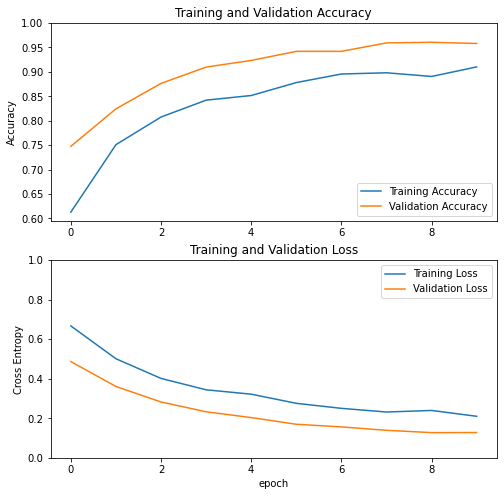

In [52]:
def plot_graphs(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
plot_graphs(history)

In [53]:
base_model.trainable = True

In [54]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [57]:
fine_tune_epochs = 10

total_epochs = initial_epochs + fine_tune_epochs

history = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data = validation_dataset)

Epoch 10/20
63/63 [==============================] - 34s 481ms/step - loss: 0.1456 - accuracy: 0.9425 - val_loss: 0.0544 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 30s 473ms/step - loss: 0.1072 - accuracy: 0.9595 - val_loss: 0.0471 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 29s 459ms/step - loss: 0.1011 - accuracy: 0.9570 - val_loss: 0.0472 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 29s 457ms/step - loss: 0.0999 - accuracy: 0.9600 - val_loss: 0.0506 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 29s 456ms/step - loss: 0.0829 - accuracy: 0.9675 - val_loss: 0.0507 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 29s 456ms/step - loss: 0.0813 - accuracy: 0.9665 - val_loss: 0.0441 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 29s 457ms/step - loss: 0.0780 - accuracy: 0.9690 - val_loss: 0.0431 - val_accuracy:

Predictions: 
 [0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0]
Labels: 
 [0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0]


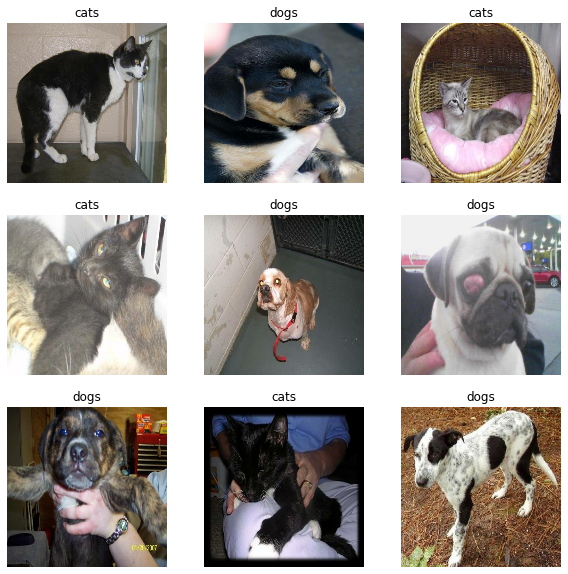

In [60]:
image_batch,label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < .5, 0, 1)

print('Predictions: \n', predictions.numpy())
print('Labels: \n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")